In [1]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = [
    "../../../figures/ssp370-plots-inputs.pdf",
    "../../../figures/ssp370-plots-outputs.pdf",
]

In [2]:
SSP370_INPUTS_FIGURE_PDF = __dest__[0]
SSP370_OUTPUTS_FIGURE_PDF = __dest__[1]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# SSP370 analysis

In [4]:
import glob
import logging

import os

import re
from pathlib import Path

# from pprint import pprint

# import pandas as pd
import pyam

import tqdm

from pymagicc.io import MAGICCData
from scmdata import df_append, ScmDataFrame

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import (
    convert_scmdf_to_pyamdf_year_only,
    load_database_files,
    prep_str_for_filename,
)

<IPython.core.display.Javascript object>

In [6]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [7]:
color_map_scenarios_base = {
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "tab:pink",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

pyam.run_control().update({"color": {"scenario": color_map_scenarios}})

<IPython.core.display.Javascript object>

## Misc functions

In [8]:
def subtract(base, other, axis, new_name):
    b_data = base.timeseries()
    o_data = other.timeseries()

    idx = b_data.index.names
    idx_tmp = list(set(idx) - {axis})

    b_data = b_data.reset_index().set_index(idx_tmp).drop(axis, axis="columns")
    o_data = o_data.reset_index().set_index(idx_tmp).drop(axis, axis="columns")

    res = (b_data - o_data).reset_index()
    res[axis] = new_name

    return pyam.IamDataFrame(res)

<IPython.core.display.Javascript object>

## Load data

### RCMIP inputs

In [9]:
SCENARIO_PROTOCOL = os.path.join(
    "..", "..", "..", "data", "protocol", "rcmip-emissions-annual-means.csv"
)
SCENARIO_PROTOCOL

'../../../data/protocol/rcmip-emissions-annual-means.csv'

<IPython.core.display.Javascript object>

In [10]:
db_protocol = ScmDataFrame(SCENARIO_PROTOCOL)
db_protocol.head()

time                                                                               1750-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1751-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1752-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1753-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1754-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable CMIP5                    NaN   
                      Emissions|CH4              Mt CH4/yr not_applicable CMIP5                    NaN   
                      Emissions|CO               Mt CO/yr  not_applicable CMIP5                    NaN   
                      Emissions|CO2              Mt CO2/yr not_applicable CMIP5                    NaN   
                      Emissions|CO2|MAGICC AFOLU Mt CO2/yr not_applicable CMIP5                    NaN   

time                                                                               1755-01-01 00:00:00  \
model scenario region variable                   unit      activity_id    mip_era                        
AIM   rcp60    World  Emissions|BC               Mt BC/yr  not_applicable

<IPython.core.display.Javascript object>

### RCMIP results

In [11]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [12]:
model_of_interest = [
    ".*acc2.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(
    Path(RESULTS_PATH).rglob("*.xlsx")
)
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 1159


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mri-cgcm3-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_emissions-ch4.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc134a.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-cams-csm1-0-calib_world_net-ocean-to-atmosphere-flux-co2.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-canesm5-calib_world_heat-content-ocean.csv']

<IPython.core.display.Javascript object>

In [13]:
variables_of_interest = [
    "Surface Air Temperature Change",
    "Surface Ocean Temperature Change",
    "Surface Air Ocean Blended Temperature Change",
    "Effective Radiative Forcing",
    "Effective Radiative Forcing|Aerosols*",
    "Effective Radiative Forcing|CH4",
]

relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 222


['../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,prob_world_effective-radiative-forcing-33th-quantile.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_escimo,rcmip,base_world_effective-radiative-forcing.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-cnrm-cm5-calib_world_surface-air-temperature-change.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip5-mpi-esm-lr-calib_world_effective-radiative-forcing.csv']

<IPython.core.display.Javascript object>

In [14]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                           1750-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1751-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1752-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                           1753-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-4xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   

time                                                                                           1754-01-01 00:00:00  \
model       scenario       region variable                    unit  climatemodel unit_context                        
unspecified 1pctCO2        World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            1pctCO2-4xext  World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-0p5xCO2 World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.000004   
            abrupt-2xCO2   World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required         

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [15]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [16]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*ssp370*.MAG"))

db_cmip = df_append(
    [load_tas_file(f).filter(region="World") for f in tqdm.tqdm_notebook(cmip_files)]
)
db_cmip.head()

time                                                                                                            1850-07-01  \
model       scenario       region variable                       unit climatemodel         mip_era source_id                 
unspecified ssp370         World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.150231   
                                                                      BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.056140   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.056140   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1       0.083741   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1       0.083741   

time                                                                                                            1851-07-01  \
model       scenario       region variable                       unit climatemodel         mip_era source_id                 
unspecified ssp370         World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.103944   
                                                                      BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.118773   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.118773   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1      -0.106856   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1      -0.106856   

time                                                                                                            1852-07-01  \
model       scenario       region variable                       unit climatemodel         mip_era source_id                 
unspecified ssp370         World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.062908   
                                                                      BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.143728   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.143728   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1       0.054221   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1       0.054221   

time                                                                                                            1853-07-01  \
model       scenario       region variable                       unit climatemodel         mip_era source_id                 
unspecified ssp370         World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR   -0.009120   
                                                                      BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.107462   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1    CMIP6   BCC-ESM1      -0.107462   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1      -0.062636   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1    CMIP6   BCC-ESM1      -0.062636   

time                                                                                                            1854-07-01  \
model       scenario       region variable                       unit climatemodel         mip_era source_id                 
unspecified ssp370         World  Surface Air Temperature Change K    BCC-CSM2-MR_r1i1p1f1 CMIP6   BCC-CSM2-MR    0.047675   
                                                                      BCC-ESM1_r1i1p1f1   

<IPython.core.display.Javascript object>

## Plot

In [17]:
filters_variables = [["Emissions|CO2"], ["Emissions|CH4"], ["Emissions|Sulfur"]]
db_plot = db_protocol.copy()
scenarios = ["ssp370", "ssp370-lowNTCF-aerchemmip", "ssp370-lowNTCF-gidden"]
region = "World"

db_plot = db_plot.filter(scenario=scenarios)
widths = [1] * len(filters_variables)
heights = [2, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig, axes_all = plt.subplots(
    figsize=(16, 9),
    ncols=len(filters_variables),
    nrows=2,
    #     constrained_layout=True,
    gridspec_kw=gs_kw,
)
for filter_variable, ax_top, ax_bottom in zip(
    filters_variables, axes_all[0], axes_all[1]
):
    pdf = db_plot.filter(variable=filter_variable, region=region)

    pdf = pdf.timeseries()
    pdf.columns = pdf.columns.map(lambda x: x.year)
    pyam.IamDataFrame(pdf).line_plot(
        color="scenario", linestyle="region", ax=ax_top, legend=True
    )

    # add differences too
    diffs = []
    for o_scen in scenarios[1:]:
        diff = pyam.IamDataFrame(pdf)
        scen_diff_label = "{} - {}".format(o_scen, scenarios[0])
        diff = subtract(
            diff.filter(scenario=o_scen),
            diff.filter(scenario=scenarios[0]),
            "scenario",
            scen_diff_label,
        )
        diffs.append(diff)

    diff = pyam.concat(diffs)
    diff.line_plot(color="scenario", legend=True, ax=ax_bottom)

    ax_bottom.set_title("")

plt.tight_layout()
plt.savefig(SSP370_INPUTS_FIGURE_PDF)

<IPython.core.display.Javascript object>

In [18]:
ssp370_models = db_cmip.filter(scenario="ssp370")["climatemodel"].unique()
ssp370_lowNTCF_models = db_cmip.filter(scenario="ssp370-lowNTCF")[
    "climatemodel"
].unique()
ssp370_models = set(ssp370_models).intersection(set(ssp370_lowNTCF_models))
db_cmip_ssp370_runs = db_cmip.filter(climatemodel=ssp370_models)
db_cmip_ssp370_runs.timeseries()

time                                                                                                       1850-07-01  \
model       scenario       region variable                       unit climatemodel      mip_era source_id               
unspecified ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.056140   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.056140   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1     0.083741   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1     0.083741   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.071678   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.071678   

time                                                                                                       1851-07-01  \
model       scenario       region variable                       unit climatemodel      mip_era source_id               
unspecified ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.118773   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.118773   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1    -0.106856   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1    -0.106856   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.071154   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.071154   

time                                                                                                       1852-07-01  \
model       scenario       region variable                       unit climatemodel      mip_era source_id               
unspecified ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.143728   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.143728   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1     0.054221   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1     0.054221   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1     0.016366   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1     0.016366   

time                                                                                                       1853-07-01  \
model       scenario       region variable                       unit climatemodel      mip_era source_id               
unspecified ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.107462   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r1i1p1f1 CMIP6   BCC-ESM1    -0.107462   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1    -0.062636   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r2i1p1f1 CMIP6   BCC-ESM1    -0.062636   
            ssp370         World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.077915   
            ssp370-lowNTCF World  Surface Air Temperature Change K    BCC-ESM1_r3i1p1f1 CMIP6   BCC-ESM1    -0.077915   

time                                                                                                       1854-07-01  \
mod

<IPython.core.display.Javascript object>

In [19]:
matplotlib.rcParams["figure.figsize"] = (6, 9)
matplotlib.rcParams["font.size"] = 6

<IPython.core.display.Javascript object>

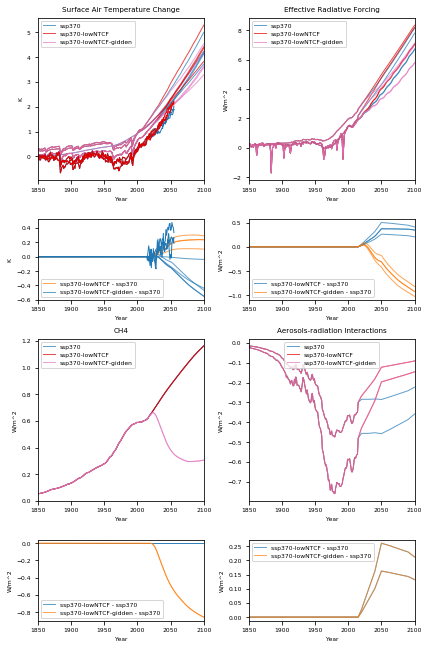

<IPython.core.display.Javascript object>

In [20]:
filters_variables = [
    ["Surface Air Temperature Change"],
    ["Effective Radiative Forcing"],
    ["Effective Radiative Forcing|Anthropogenic|CH4"],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions"
    ],
]
db_plot = db.timeseries().reset_index()
db_plot["scenario"] = db_plot["scenario"].apply(
    lambda x: "ssp370-lowNTCF" if x == "ssp370-lowNTCF-aerchemmip" else x
)
db_plot = ScmDataFrame(db_plot)
scenarios = ["ssp370", "ssp370-lowNTCF", "ssp370-lowNTCF-gidden"]
region = "World"
ignore_climatemodels = [
    "MAGICC7.1.0.beta_*NORCPM1*",
    "MAGICC7.1.0.beta_*CNRM-CM6-1-HR*",
    "MAGICC7.1.0.beta_*MPI-ESM1-2-HR*",
]  # , "hector*-CALIB"]

db_plot = db_plot.filter(scenario=scenarios, year=range(1850, 2101)).filter(
    climatemodel=ignore_climatemodels, keep=False
)
widths = [1, 1]
heights = [2, 1, 2, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig, axes_all = plt.subplots(
    ncols=2,
    nrows=4,
    #     constrained_layout=True,
    gridspec_kw=gs_kw,
)
axes_tops = [a for a in axes_all[0]] + [a for a in axes_all[2]]
axes_bottoms = [a for a in axes_all[1]] + [a for a in axes_all[3]]
for filter_variable, ax_top, ax_bottom in zip(
    filters_variables, axes_tops, axes_bottoms
):
    pdf = db_plot.filter(variable=filter_variable, region=region)

    pdf = pdf.timeseries()
    pdf.columns = pdf.columns.map(lambda x: x.year)
    pyam.IamDataFrame(pdf).line_plot(
        color="scenario", ax=ax_top, legend=True, linewidth=1, alpha=0.7
    )
    if "Surface Air Temperature Change" in filter_variable[0]:
        pdf_cmip = db_cmip_ssp370_runs.filter(variable=filter_variable, region=region)
        pdf_cmip = pdf_cmip.timeseries()
        pdf_cmip.columns = pdf_cmip.columns.map(lambda x: x.year)
        pyam.IamDataFrame(pdf_cmip).line_plot(
            color="scenario", ax=ax_top, legend=True, linewidth=1, zorder=2
        )

    ax_top.set_title(filter_variable[0].split("|")[-1])

    # add differences too
    diffs = []
    for o_scen in scenarios[1:]:
        diff = pyam.IamDataFrame(pdf)
        scen_diff_label = "{} - {}".format(o_scen, scenarios[0])
        diff = subtract(
            diff.filter(scenario=o_scen),
            diff.filter(scenario=scenarios[0]),
            "scenario",
            scen_diff_label,
        )
        diffs.append(diff)

    diff = pyam.concat(diffs)
    diff.line_plot(color="scenario", legend=True, ax=ax_bottom, linewidth=1, alpha=0.7)

    if "Surface Air Temperature Change" in filter_variable[0]:
        diff = pyam.IamDataFrame(pdf_cmip)
        scen_diff_label = "{} - {}".format("ssp370-lowNTCF", "ssp370")
        diff = subtract(
            diff.filter(scenario="ssp370-lowNTCF"),
            diff.filter(scenario="ssp370"),
            "scenario",
            scen_diff_label,
        )
        diff.line_plot(
            color="scenario", legend=True, ax=ax_bottom, linewidth=1, zorder=2
        )

    ax_bottom.set_title("")

plt.tight_layout()
plt.savefig(SSP370_OUTPUTS_FIGURE_PDF)